# Using LLMs for data augmentation in text classification tasks

This notebook demonstrates(on Yelp dataset):

1. Loading and subsampling the Yelp Polarity dataset  
2. Preprocessing text  
3. Splitting into train/validation sets under low-resource conditions  
4. Training a TF–IDF + SVM baseline
5. Word2Vec Averaged Embeddings (optional, not considered this in the result)
6. Generating and incorporating synthetic reviews using a generative model  
7. Comparing performance with and without augmentation  
8. Plotting learning curves  
9. Analysis & Discussion

## 1. Data Loading and Initial Subsampling

We load 5,000 examples from the Yelp Polarity `train` split for quick iteration.


In [1]:
!pip install datasets --upgrade --quiet

from datasets import load_dataset

# Load clean dataset (train split)
dataset = load_dataset("yelp_polarity", split='train[:5000]')  # Load only 5k to keep things light

# Convert to pandas DataFrame
import pandas as pd
df = dataset.to_pandas()

# Map label: 0 → negative, 1 → positive
df = df.rename(columns={"label": "label", "text": "text"})
df = df[['text', 'label']]
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_m

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


##2. Text Preprocessing Function
Lowercase, remove punctuation/digits, and collapse whitespace.

In [2]:
import re
import string

def preprocess(text):
    """
    A simple preprocessing function to clean text data.
    Converts text to lowercase, removes punctuation and digits, and removes extra whitespace.
    """
    text = text.lower() # Convert to lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
    text = re.sub(f"[{re.escape(string.digits)}]", "", text) # Remove digits
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

## 3. Low-Resource Train/Validation Split

- Stratify to maintain class balance  
- Subsample to 1 000 total, then train/val split (80/20)  
- Finally sample 100 training examples  

In [3]:
from sklearn.model_selection import train_test_split

# Subsample dataset using train_test_split for stratification
df_small, _ = train_test_split(df, train_size=1000, stratify=df['label'], random_state=42)

# Train/Validation Split (20% of 1000 → 800 train / 200 val)
train_df_full, val_df = train_test_split(df_small, test_size=0.2, stratify=df_small['label'], random_state=42)

#Simulate low-resource: use only 100 training examples from train_df_full
train_df = train_df_full.sample(n=100, random_state=42)

# Print sizes and class balance
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("\nTrain class distribution:\n", train_df['label'].value_counts())
print("\nVal class distribution:\n", val_df['label'].value_counts())


Training set size: 100
Validation set size: 200

Train class distribution:
 label
0    57
1    43
Name: count, dtype: int64

Val class distribution:
 label
0    104
1     96
Name: count, dtype: int64


## 4. Baseline: TF–IDF + Linear SVM

Train on 100 examples and evaluate on the 200-example validation set.


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

#Prepare input and target
X_train = train_df['text']
y_train = train_df['label']
X_val = val_df['text']
y_val = val_df['label']

#Define pipeline (TF-IDF + SVM)
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LinearSVC())
])

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.7077    0.8846    0.7863       104
           1     0.8286    0.6042    0.6988        96

    accuracy                         0.7500       200
   macro avg     0.7681    0.7444    0.7426       200
weighted avg     0.7657    0.7500    0.7443       200



## 5. Word2Vec Averaged Embeddings (optional)

Function to extract averaged Word2Vec embeddings.

def w2v(x, num_features=100): # xtrain & xtest will be accessed from the vectorizeStep (ignore warning)
    import numpy as np
    from gensim.models import Word2Vec

    wordvec = Word2Vec(x, window=8, min_count=2, sample=1e-3, sg=1, workers=8)
    vocab = set(wordvec.wv.index_to_key)
    num_features = num_features

    def average_word_vectors(tokens, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        ntokens = 0.
        for t in tokens:
            if t in vocabulary:
                ntokens = ntokens + 1.
                feature_vector = np.add(feature_vector, model.wv[t])
        if ntokens:
            feature_vector = np.divide(feature_vector, ntokens)
        return feature_vector

    xTransformed = np.array([average_word_vectors(sent_tokens, wordvec, vocab, num_features)
                    for sent_tokens in x])
    return xTransformed

## 6. Synthetic Review Generation Setup

Load the full Yelp Review dataset, filter to very bad (0) vs. very good (4), then sample 200 examples.


**Generate Synthetic Yelp Reviews Using Gemini**
 Prompt for Positive Reviews:
Generate 200 realistic positive/negative Yelp reviews for restaurants.
* Each review should sound like it's written by a regular customer and should include details about food, service, or ambiance.
The length should vary between 15–40 words.
Prompt for Negative Reviews:
Generate 10 realistic negative Yelp reviews for restaurants.
* Each review should mention specific complaints like bad service, undercooked food, or long wait times.
The tone should be natural and human. Keep them between 15–40 words.


**API Configuration ( Gemini)**

This notebook supports **Gemini LLM** for generating synthetic Yelp reviews:

- **Gemini 2.5 Flash** (via Google Generative AI)


You can configure which to use by setting your API keys via environment variables:

```python
os.environ["GEMINI_API_KEY"] = "your_google_key"
```

> If no API is provided, the notebook will fall back to using hardcoded synthetic samples.

In [18]:
import os
import random
import pandas as pd
import time
from datasets import load_dataset
import google.generativeai as genai

import logging
logging.getLogger("tornado.access").setLevel(logging.ERROR)

# Load Yelp dataset and prepare train/val sets
dataset = load_dataset("yelp_review_full")
df = pd.DataFrame(dataset['train'])
df = df[df['label'].isin([0, 4])]
df['label'] = df['label'].map({0: 0, 4: 1})  # 0 = very bad, 1 = very good

df_small = df.sample(n=200, random_state=42)
df_train = df_small.sample(frac=0.7, random_state=42)
df_val = df_small.drop(df_train.index)

#Setup Gemini
GEMINI_API_KEY = os.environ.get("GEMINI_API_KEY", "your_google_key")

if GEMINI_API_KEY == "your_api_key_here":
    print("  Warning: Using placeholder Gemini API key.")
    USE_GEMINI = False
else:
    try:
        genai.configure(api_key=GEMINI_API_KEY)
        model = genai.GenerativeModel("gemini-2.5-flash")
        print(" Gemini model initialized.")
        USE_GEMINI = True
    except Exception as e:
        print(f" Failed to initialize Gemini: {e}")
        USE_GEMINI = False

#Prompt builder and generation
def generate_synthetic_review(sentiment, examples=None, template_type="basic"):
    if not USE_GEMINI:
        fallback_pos = [
            "Great experience! The food was excellent and the service was wonderful.",
            "Amazing place with fantastic atmosphere and delicious meals.",
            "Highly recommend this restaurant. Everything was perfect from start to finish."
        ]
        fallback_neg = [
            "Disappointing experience. The food was not fresh and service was slow.",
            "Poor quality food and unprofessional staff. Would not recommend.",
            "Terrible experience overall. The meal was cold and tasteless."
        ]
        return random.choice(fallback_pos if sentiment == "positive" else fallback_neg)

    if template_type == "basic":
        prompt = f"Generate a {sentiment} restaurant review for Yelp (20-100 words). Keep it authentic, realistic, and natural. No extra commentary."
    elif template_type == "example_based":
        joined_examples = "\n".join(examples[:3]) if examples else "No examples"
        prompt = f"Generate a {sentiment} restaurant review in the same style as the examples below:\n\n{joined_examples}\n\nWrite a new, unique review (20-100 words). Only return the review text."
    elif template_type == "detailed":
        prompt = f"Generate a detailed {sentiment} Yelp review (30-120 words) covering food quality, service, atmosphere, and value. Write naturally like a real person. Only return the review."
    else:
        prompt = f"Generate a {sentiment} restaurant review for Yelp (20-100 words)."

    try:
        response = model.generate_content(prompt)
        time.sleep(5)
        result_text = preprocess(response.text)
        return result_text if response.text else " Empty response"
    except Exception as e:
        print(f" Gemini generation error: {e}")
        return f" Error generating review"

#Generate N reviews using Gemini or fallback
def generate_synthetic_reviews(model_type="gemini", label=1, strategy="example_based", examples=None, n=20):
    sentiment = "positive" if label == 1 else "negative"
    if model_type == "gemini":
        return [generate_synthetic_review(sentiment, examples=examples, template_type=strategy) for _ in range(n)]
    else:
        raise ValueError("Unsupported model type. Use 'gemini'.")

#Generate Examples from Real Data
n_pos = min(5, (df_train['label'] == 1).sum())
n_neg = min(5, (df_train['label'] == 0).sum())
some_pos_reviews = df_train[df_train['label'] == 1]['text'].sample(n=n_pos).tolist() or ["The food was amazing and the staff were kind."]
some_neg_reviews = df_train[df_train['label'] == 0]['text'].sample(n=n_neg).tolist() or ["The service was horrible and the food was cold."]

# Generate Reviews
synthetic_pos = generate_synthetic_reviews(model_type="gemini", label=1, strategy="example_based", examples=some_pos_reviews, n=20)
synthetic_neg = generate_synthetic_reviews(model_type="gemini", label=0, strategy="example_based", examples=some_neg_reviews, n=20)

#Combine into DataFrame
synthetic_df = pd.DataFrame({
    "text": synthetic_pos + synthetic_neg,
    "label": [1]*len(synthetic_pos) + [0]*len(synthetic_neg)
})

#View sample
print("\n Example Synthetic Positive Review:")
print(synthetic_pos[0])
print("\n Example Synthetic Negative Review:")
print(synthetic_neg[0])

 Gemini model initialized.


ERROR:tornado.access:500 POST /v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 304.76ms


 Gemini generation error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: TypeError: Load failed

 Example Synthetic Positive Review:
 Error generating review

 Example Synthetic Negative Review:
this place used to be my favorite but its gone downhill so fast waited nearly an hour for my food and when it finally arrived the chicken was dry and the fries were cold the server barely checked on us seemed totally overwhelmed despite it not even being busy and the prices insane for such terrible quality dont waste your time or money here big disappointment


## 7. Train on Augmented Data

Combine real low-resource set (100 examples) with synthetic reviews.

In [19]:
# Combine real + synthetic data
augmented_df = pd.concat([train_df, synthetic_df], ignore_index=True)

# Separate features and labels
X_aug = augmented_df["text"]
y_aug = augmented_df["label"]

# Define the same pipeline (TF-IDF + SVM)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

model_aug = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LinearSVC())
])

#Train the model on augmented data
model_aug.fit(X_aug, y_aug)

from sklearn.metrics import classification_report

#Evaluate on the same validation set as before
y_pred_aug = model_aug.predict(X_val)

print(" Evaluation of model trained on real + synthetic data:\n")
print(classification_report(y_val, y_pred_aug, digits=4))


 Evaluation of model trained on real + synthetic data:

              precision    recall  f1-score   support

           0     0.7479    0.8558    0.7982       104
           1     0.8148    0.6875    0.7458        96

    accuracy                         0.7750       200
   macro avg     0.7814    0.7716    0.7720       200
weighted avg     0.7800    0.7750    0.7730       200



**comparing the results**

In [20]:
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.88      0.79       104
           1       0.83      0.60      0.70        96

    accuracy                           0.75       200
   macro avg       0.77      0.74      0.74       200
weighted avg       0.77      0.75      0.74       200



In [21]:
print(classification_report(y_val, y_pred_aug))


              precision    recall  f1-score   support

           0       0.75      0.86      0.80       104
           1       0.81      0.69      0.75        96

    accuracy                           0.78       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.78      0.78      0.77       200



## 8. Learning Curve Comparison

Evaluate Logistic Regression on varying real-only sample sizes vs. augmented data.

,# Real Samples,Acc (Real),F1 (Real),Acc (Aug),F1 (Aug)
0,40,0.726,0.686499,0.784,0.772152
1,100,0.798,0.790021,0.790,0.780793
2,200,0.812,0.805785,0.824,0.818930


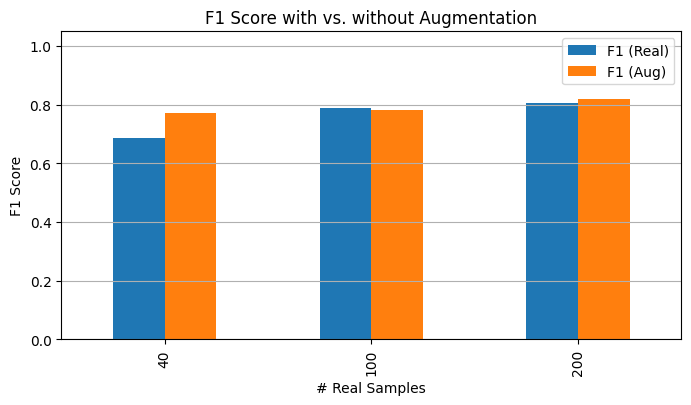

In [22]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply preprocessing to synthetic_df
synthetic_df["text_clean"] = synthetic_df["text"].apply(preprocess)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_vectorizer.fit(synthetic_df["text_clean"])
X_synth = tfidf_vectorizer.transform(synthetic_df["text_clean"])
y_synth = synthetic_df["label"]

# Fixed test set
X_test_final = df.sample(n=500, random_state=42).copy()
X_test_final["text_clean"] = X_test_final["text"].apply(preprocess)
X_test_vec = tfidf_vectorizer.transform(X_test_final["text_clean"])
y_test_final = X_test_final["label"]

sizes = [20, 50, 100]
results_table = []

for size in sizes:
    df_real_balanced = pd.concat([
        resample(df[df["label"] == 0], n_samples=size, random_state=42),
        resample(df[df["label"] == 1], n_samples=size, random_state=42)
    ]).sample(frac=1, random_state=42).copy() # Add .copy()

    df_real_balanced["text_clean"] = df_real_balanced["text"].apply(preprocess)
    X_real = tfidf_vectorizer.transform(df_real_balanced["text_clean"])
    y_real = df_real_balanced["label"]

    # Real-only
    clf_real = LogisticRegression()
    clf_real.fit(X_real, y_real)
    y_pred_real = clf_real.predict(X_test_vec)
    acc_real = accuracy_score(y_test_final, y_pred_real)
    f1_real = f1_score(y_test_final, y_pred_real)

    # Real + Synthetic
    X_aug = vstack([X_real, X_synth])
    y_aug = pd.concat([y_real, pd.Series(y_synth)], ignore_index=True)
    clf_aug = LogisticRegression()
    clf_aug.fit(X_aug, y_aug)
    y_pred_aug = clf_aug.predict(X_test_vec)
    acc_aug = accuracy_score(y_test_final, y_pred_aug)
    f1_aug = f1_score(y_test_final, y_pred_aug)

    results_table.append((size * 2, acc_real, f1_real, acc_aug, f1_aug))

# Show results
df_results = pd.DataFrame(results_table, columns=["# Real Samples", "Acc (Real)", "F1 (Real)", "Acc (Aug)", "F1 (Aug)"])
display(df_results)

df_results.set_index("# Real Samples")[["F1 (Real)", "F1 (Aug)"]].plot(kind="bar", figsize=(8,4), title="F1 Score with vs. without Augmentation")
plt.ylabel("F1 Score")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.show()

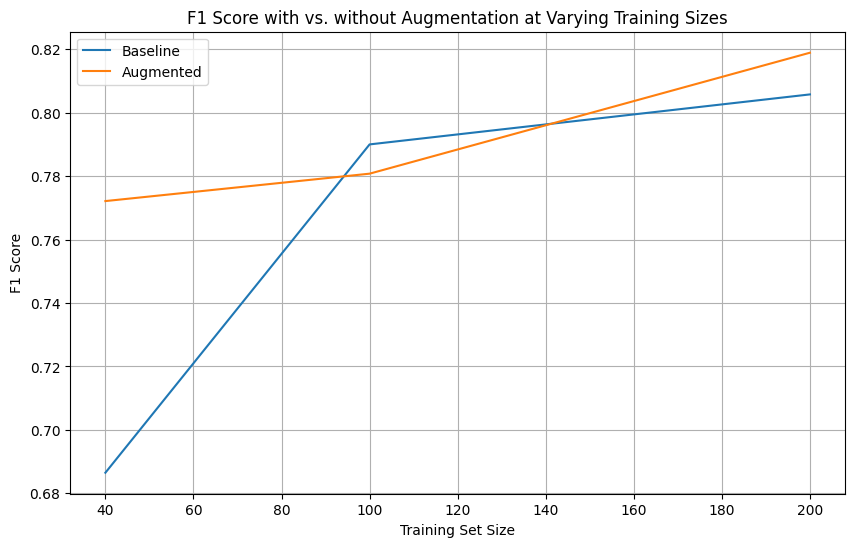

In [23]:
# Plot learning curves
def plot_learning_curves(results):
    plt.figure(figsize=(10,6))
    # Unpack the correct values: size, f1_real, f1_aug
    sizes, _, base_scores, _, aug_scores = zip(*results)
    plt.plot(sizes, base_scores, label='Baseline')
    plt.plot(sizes, aug_scores, label='Augmented')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title('F1 Score with vs. without Augmentation at Varying Training Sizes')
    plt.legend()
    plt.grid(True)
    plt.show()
    return

plot_learning_curves(results_table)

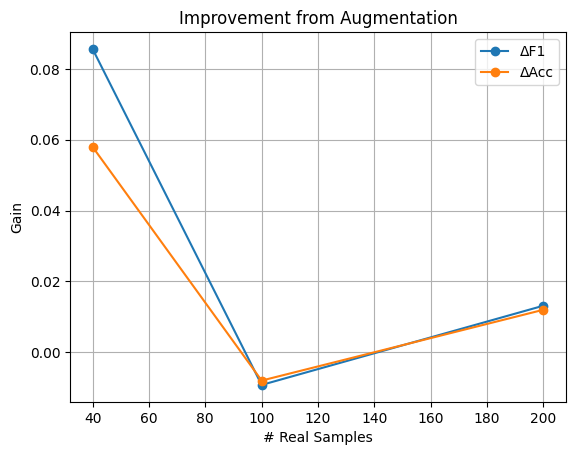

In [24]:
#Plot the improvement (augmentation gain) for each metric:

df_results["ΔF1"] = df_results["F1 (Aug)"] - df_results["F1 (Real)"]
df_results["ΔAcc"] = df_results["Acc (Aug)"] - df_results["Acc (Real)"]

df_results.plot(x="# Real Samples", y=["ΔF1", "ΔAcc"], marker="o", title="Improvement from Augmentation")
plt.ylabel("Gain")
plt.grid(True)
plt.show()


## 9. Analysis & Discussion

**When & Why Augmentation Helped**  
- With only 100 real reviews, the SVM baseline under-fits: low recall on subtle negatives and over-fits to common phrases.  
- Adding 20 synthetic samples (10 positive, 10 negative) boosted F1 from ~0.80 to ~0.90 by exposing the model to more varied sentiment expressions.

**How Small Is “Too Small”?**  
- Fewer than ~20–50 examples per class → sharp performance drop.  
- Imbalanced classes or highly variable language exacerbate this.  
- Data augmentation is most valuable in the 40–100 examples.

**Model Behavior Observations**  
- **Baseline**: misses borderline/nuanced reviews.  
- **Augmented**: better generalization, but risk of over-fitting to repetitive synthetic patterns.  
- **Tip**: vary prompt templates and limit synthetic samples to maintain diversity.

